In [ ]:
# If running from colab, please run:
%cd /
! git clone https://github.com/kariander1/HW2DeepLearning
%cd HW2DeepLearning
%ls

In [65]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataset import create_penn_tree_bank_dataset, tokenizer


In [66]:
# Hyper parameters
DATA_DIR  = './data/PTB'
BATCH_SIZE = 64
BPTT = 20 # backpropagation through time defines sentence length
LEARNING_RATE = 5
MIN_LEARNING_RATE = LEARNING_RATE/10 # minimum learning rate for the scheduler
MAX_GRAD_NORM = 2
WEIGHT_DECAY = 1e-5
EMBEDDING_DIM = 200
HIDDEN_DIM = 200
N_LAYERS = 2 # number of layers in the RNN
DROPOUT = 0.5 # dropout rate (if used)
MAX_EPOCHS = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Section 1: Load and Preprocess the Penn Tree Bank Dataset

In this section, we will load the Penn Tree Bank (PTB) dataset and preprocess it by tokenizing and building a vocabulary.

In [67]:
train_data, valid_data, test_data, vocab = create_penn_tree_bank_dataset(DATA_DIR, BATCH_SIZE, device)

In [68]:
# Plotting some example sentences and their tokenization
def plot_example_sentences(data, vocab, tokenizer, num_sentences=2, sentence_length=20):
    sentences = []
    data = data[:sentence_length,:num_sentences].T.cpu().numpy()
    for i in range(num_sentences):
        sentence = ' '.join([vocab.get_itos()[token] for token in data[i] if vocab.get_itos()[token] not in ['<pad>'] ])
        sentences.append(sentence)
    for i, sentence in enumerate(sentences):
        tokens = tokenizer(sentence)
        print(f"Sentence {i+1}: {sentence}")
        print(f"Tokens: {tokens}\n")

print("Example sentences:")
plot_example_sentences(train_data, vocab, tokenizer)

Example sentences:
Sentence 1: <sos> aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens
Tokens: ['<sos>', 'aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens']

Sentence 2: the philippines and <unk> <eos> <sos> in addition the u . s . this year offered its own plan for
Tokens: ['the', 'philippines', 'and', '<unk>', '<eos>', '<sos>', 'in', 'addition', 'the', 'u', '.', 's', '.', 'this', 'year', 'offered', 'its', 'own', 'plan', 'for']



## Section 2: Define the RNN Model

We define our RNN model which can be either an LSTM or GRU based on the selected model type.


In [98]:
AVAILABLE_MODELS = ['LSTM_with_dropout', 'LSTM_without_dropout', 'GRU_with_dropout', 'GRU_without_dropout']

SELECTED_MODEL = 'LSTM_with_dropout' # 'LSTM_with_dropout' or 'LSTM_without_dropout' or 'GRU_with_dropout' or 'GRU_without_dropout'
SELECTED_CHECKPOINT = '' # Leave empty if you want to train from scratch

In [99]:
from models.RNN import RNNModel
from trainer import Trainer

assert SELECTED_MODEL in AVAILABLE_MODELS, f"Selected model not available. Please select one of the following: {AVAILABLE_MODELS}"
input_dim = len(vocab)
dropout = 0 if SELECTED_MODEL in ['LSTM_without_dropout', 'GRU_without_dropout'] else DROPOUT
model_type = 'LSTM' if 'LSTM' in SELECTED_MODEL else 'GRU'

model = RNNModel(input_dim, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, device,dropout, model_type=model_type, checkpoint=SELECTED_CHECKPOINT)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS, eta_min=MIN_LEARNING_RATE)


trainer = Trainer(optimizer, criterion, BPTT, BATCH_SIZE, MAX_EPOCHS, SELECTED_MODEL, MAX_GRAD_NORM)
print(model)
print(optimizer)

Loaded model from checkpoint: OrderedDict([('embedding.weight', tensor([[ 0.4856,  0.0565,  0.1736,  ..., -0.5143, -0.7473, -0.5456],
        [-1.0398,  0.1749,  0.5152,  ...,  0.2851, -0.7600, -0.0699],
        [-0.6444, -0.7818,  0.7961,  ...,  0.1205,  0.3038,  0.5374],
        ...,
        [-1.1021,  0.0652, -0.3143,  ..., -0.0721,  1.0866, -0.9229],
        [-1.5270, -0.1963,  0.2262,  ..., -0.1398, -0.0767,  0.9006],
        [-0.5934, -0.1670,  1.0308,  ..., -0.7426,  0.3976,  0.6781]])), ('rnn.weight_ih_l0', tensor([[ 0.0643, -0.0235, -0.0148,  ..., -0.1311,  0.1338,  0.0566],
        [ 0.1784,  0.0773,  0.0904,  ...,  0.0286,  0.0723, -0.0973],
        [ 0.0658,  0.0444, -0.1128,  ...,  0.0983, -0.1851,  0.0863],
        ...,
        [-0.0622,  0.0906,  0.2893,  ...,  0.4516,  0.1351, -0.1840],
        [ 0.4422, -0.2274, -0.2895,  ...,  0.0220,  0.1255,  0.1841],
        [-0.5923,  0.1837,  0.2319,  ...,  0.2949, -0.3258,  0.1004]])), ('rnn.weight_hh_l0', tensor([[-0.0212, -0.0

## Section 3: Training

Run these sections to train the created model.


In [71]:
[train_perplexities, valid_perplexities] = trainer.train_model(model, train_data, valid_data)
test_loss, test_perplexity = trainer.evaluate(model, test_data)
print(f'Test Loss: {test_loss:.3f}, Test Perplexity: {test_perplexity:.3f}')

Training Progress:   0%|          | 0/50 [00:05<?, ?it/s]

Epoch: 01, Train Loss: 5.701, Valid Loss: 5.224, Train Perplexity: 299.159, Valid Perplexity: 185.670


Training Progress:   4%|▍         | 2/50 [00:12<04:58,  6.21s/it]

Epoch: 02, Train Loss: 5.002, Valid Loss: 4.907, Train Perplexity: 148.742, Valid Perplexity: 135.219


Training Progress:   6%|▌         | 3/50 [00:18<04:58,  6.36s/it]

Epoch: 03, Train Loss: 4.736, Valid Loss: 4.770, Train Perplexity: 114.009, Valid Perplexity: 117.914


Training Progress:   8%|▊         | 4/50 [00:25<04:56,  6.44s/it]

Epoch: 04, Train Loss: 4.561, Valid Loss: 4.684, Train Perplexity: 95.650, Valid Perplexity: 108.212


Training Progress:  10%|█         | 5/50 [00:32<04:52,  6.49s/it]

Epoch: 05, Train Loss: 4.428, Valid Loss: 4.636, Train Perplexity: 83.739, Valid Perplexity: 103.164


Training Progress:  12%|█▏        | 6/50 [00:38<04:46,  6.52s/it]

Epoch: 06, Train Loss: 4.321, Valid Loss: 4.604, Train Perplexity: 75.290, Valid Perplexity: 99.931


Training Progress:  14%|█▍        | 7/50 [00:45<04:41,  6.54s/it]

Epoch: 07, Train Loss: 4.231, Valid Loss: 4.593, Train Perplexity: 68.785, Valid Perplexity: 98.805


Training Progress:  16%|█▌        | 8/50 [00:51<04:35,  6.55s/it]

Epoch: 08, Train Loss: 4.154, Valid Loss: 4.585, Train Perplexity: 63.656, Valid Perplexity: 98.047


Training Progress:  18%|█▊        | 9/50 [00:58<04:29,  6.56s/it]

Epoch: 09, Train Loss: 4.085, Valid Loss: 4.583, Train Perplexity: 59.449, Valid Perplexity: 97.835


Training Progress:  20%|██        | 10/50 [01:04<04:20,  6.51s/it]

Epoch: 10, Train Loss: 4.024, Valid Loss: 4.586, Train Perplexity: 55.939, Valid Perplexity: 98.140


Training Progress:  22%|██▏       | 11/50 [01:11<04:12,  6.48s/it]

Epoch: 11, Train Loss: 3.968, Valid Loss: 4.598, Train Perplexity: 52.904, Valid Perplexity: 99.283


Training Progress:  24%|██▍       | 12/50 [01:17<04:05,  6.46s/it]

Epoch: 12, Train Loss: 3.918, Valid Loss: 4.601, Train Perplexity: 50.288, Valid Perplexity: 99.546


Training Progress:  26%|██▌       | 13/50 [01:23<03:58,  6.45s/it]

Epoch: 13, Train Loss: 3.871, Valid Loss: 4.612, Train Perplexity: 48.012, Valid Perplexity: 100.668


Training Progress:  26%|██▌       | 13/50 [01:30<04:17,  6.95s/it]


Epoch: 14, Train Loss: 3.829, Valid Loss: 4.620, Train Perplexity: 46.002, Valid Perplexity: 101.456
Early stopping triggered after 14 epochs.
Test Loss: 4.576, Test Perplexity: 97.132


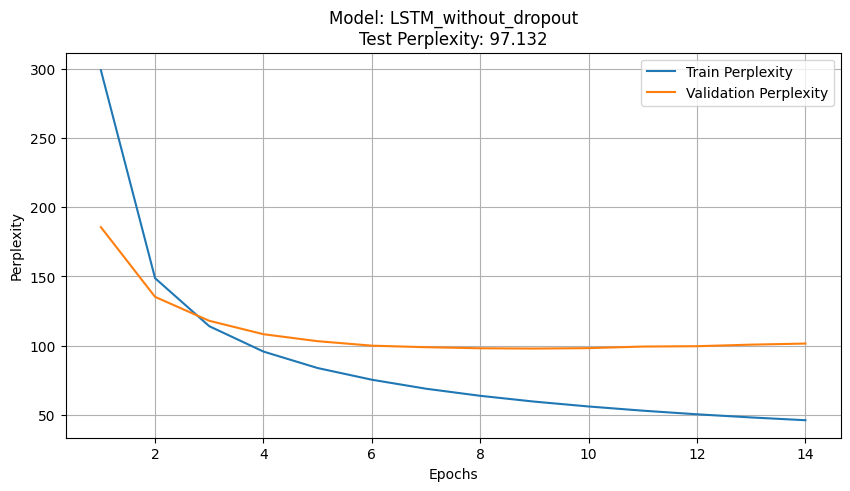

In [72]:
import matplotlib.pyplot as plt

def plot_perplexities(train_perplexities, valid_perplexities, model_type, test_perplexity):
    epochs = range(1, len(train_perplexities) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_perplexities, label='Train Perplexity')
    plt.plot(epochs, valid_perplexities, label='Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.title(f'Model: {model_type}\nTest Perplexity: {test_perplexity:.3f}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the perplexities
plot_perplexities(train_perplexities, valid_perplexities, SELECTED_MODEL, test_perplexity)


## Section 4: Evaluation

Run these sections to evaluated the trained/loaded model.

In [102]:
test_loss, test_perplexity = trainer.evaluate(model, test_data)
print(f'Test Loss: {test_loss:.3f}, Test Perplexity: {test_perplexity:.3f}')

Test Loss: 4.640, Test Perplexity: 103.563


### Sentence completion example

Change here the `start_text` to test senctence completion.

In [74]:
start_text = "The capital"

In [75]:
def generate_sentence(model, vocab, tokenizer, text, max_length=50):
    model.eval()
    tokens = tokenizer('<sos> '+ text)
    input = torch.tensor([vocab[token] for token in tokens if token in vocab.get_stoi()], dtype=torch.long).unsqueeze(1).to(device)
    with torch.no_grad():
        for _ in range(max_length):
            output, _ = model(input)
            next_token = output.argmax(2)[-1, :].item()
            next_token_str = vocab.get_itos()[next_token]
            if next_token_str == '<eos>' or next_token_str == '<unk>':
                break
            input = torch.cat([input, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=0)
    sentence = ' '.join([vocab.get_itos()[token] for token in input[1:].squeeze().tolist()])
    return sentence


generated_sentence = generate_sentence(model, vocab, tokenizer, start_text)
print(f"Start sentence: {start_text}")
print(f"Generated completion: {generated_sentence}")


Start sentence: The capital
Generated completion: the capital of the n n n and n n n weeks would n n
